In [1]:
# import tensorflow as tf
# from tensorflow import keras

import numpy as np
import os
import cv2

# from tensorflow.keras.preprocessing.image import ImageDataGenerator


from pathlib import Path
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

# load env variables, for data path
dotenv_path = Path().absolute() / '.env'
if dotenv_path.exists():
    load_dotenv(dotenv_path)
    
from covid_xrays_model import config

In [4]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, top_percent, size):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

def random_ratio_resize(img, prob=0.3, delta=0.1):
    if np.random.rand() >= prob:
        return img
    ratio = img.shape[0] / img.shape[1]
    ratio = np.random.uniform(max(ratio - delta, 0.01), ratio + delta)

    if ratio * img.shape[1] <= img.shape[1]:
        size = (int(img.shape[1] * ratio), img.shape[1])
    else:
        size = (img.shape[0], int(img.shape[0] / ratio))

    dh = img.shape[0] - size[1]
    top, bot = dh // 2, dh - dh // 2
    dw = img.shape[1] - size[0]
    left, right = dw // 2, dw - dw // 2

    if size[0] > 480 or size[1] > 480:
        print(img.shape, size, ratio)

    img = cv2.resize(img, size)
    img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT,
                             (0, 0, 0))

    if img.shape[0] != 480 or img.shape[1] != 480:
        raise ValueError(img.shape, size)
    return img

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = random_ratio_resize(img)
    img = _augmentation_transform.random_transform(img)
    return img

def _process_csv_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files


NameError: name 'ImageDataGenerator' is not defined

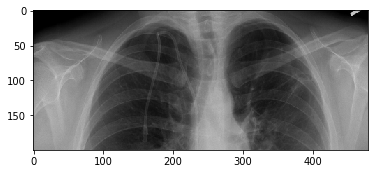

In [76]:
plt.imshow(x[0, 0:200, :])

In [111]:
image_file = '/home/doaa/Git/covid_xrays/data/processed/test_original.jpg'

size = 100

# img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

img = crop_top(img, percent=0.4)
# img = central_crop(img)
img = cv2.resize(img, (size, size))
    

In [112]:
img.shape

(100, 100)

In [50]:
cv2.imwrite('/home/doaa/Git/covid_xrays/data/processed/test.jpg', img)

True

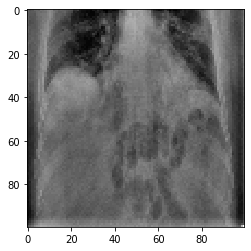

In [113]:
plt.imshow(img, cmap='gray')

# FASTAI model

In [197]:
from fastai.vision import *
from fastai.vision import models
import pandas as pd
import joblib
from covid_xrays_model.processing.data_management import load_dataset, _get_image_transformation

In [87]:
sample_size = 100000
image_size = 200


labels = pd.read_csv(config.PROCESSED_DATA_DIR / 'labels_full.csv')

classes = ['pneumonia', 'normal', 'COVID-19']
ds_types = ['train']
selected = []
for c in classes:
    for t in ds_types:
        selected.extend(labels[(labels.label == c) & (labels.ds_type == t)][:sample_size].values.tolist())

subset = pd.DataFrame(selected, columns=labels.columns)
subset[['name', 'label']].to_csv(config.PROCESSED_DATA_DIR / 'labels.csv', index=False)

subset

,patient,name,label,dataset,ds_type
0,3,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8a...,pneumonia,cohen,train
1,3,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8b...,pneumonia,cohen,train
2,3,train/SARS-10.1148rg.242035193-g04mr34g0-Fig8c...,pneumonia,cohen,train
3,7,train/SARS-10.1148rg.242035193-g04mr34g04a-Fig...,pneumonia,cohen,train
4,7,train/SARS-10.1148rg.242035193-g04mr34g04b-Fig...,pneumonia,cohen,train
...,...,...,...,...,...
13818,COVID-19(120),train/COVID-19(120).png,COVID-19,sirm,train
13819,COVID-19(121),train/COVID-19(121).png,COVID-19,sirm,train
13820,COVID-19(130),train/COVID-19(130).png,COVID-19,sirm,train
13821,COVID-19(132),train/COVID-19(132).png,COVID-19,sirm,train


In [88]:
subset.ds_type.value_counts()

train    13823
Name: ds_type, dtype: int64

In [89]:
tfms = _get_image_transformation()

data = ImageDataBunch.from_csv(config.PROCESSED_DATA_DIR,
                                   ds_tfms=tfms,
                                   csv_labels=config.PROCESSED_DATA_DIR / 'labels.csv',
                                   valid_pct=0.2,
#                                    test='test',  # useless,
                                   seed=config.SEED,
                                   size=image_size,
                                   bs=128)
data

ImageDataBunch;

Train: LabelList (11059 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Valid: LabelList (2764 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: CategoryList
normal,normal,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Test: None

In [219]:
# data = load_dataset(image_size=420, sample_size=5000)
data

ImageDataBunch;

Train: LabelList (9582 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Valid: LabelList (2395 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
normal,normal,normal,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Test: None

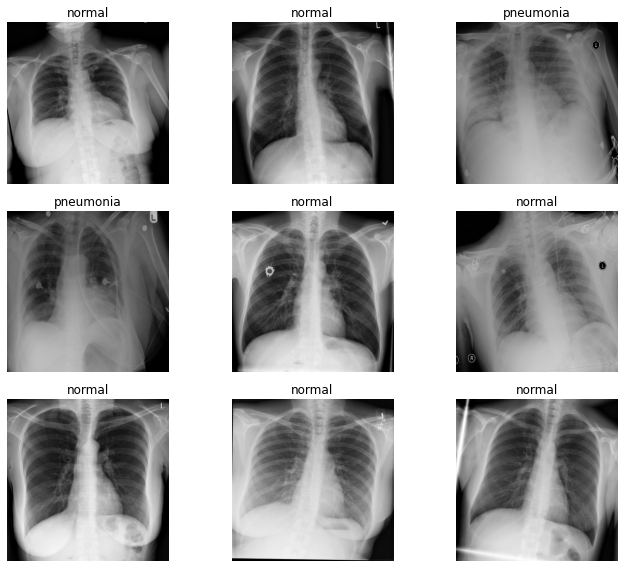

In [42]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Train)


In [10]:
# data.train_ds
data.classes, len(data.train_ds), len(data.valid_ds), data.c

(['COVID-19', 'normal', 'pneumonia'], 1280, 320, 3)

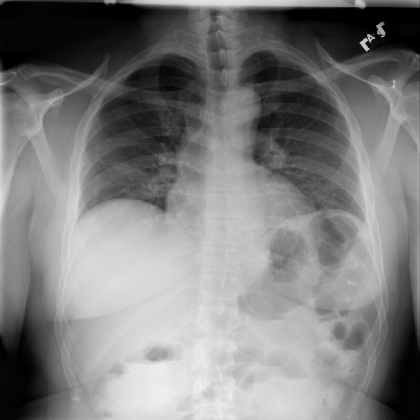

In [43]:
data.test_ds[0][0]

In [49]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)


In [50]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.046107,0.795422,0.729560,04:31


In [182]:
learn.data = data

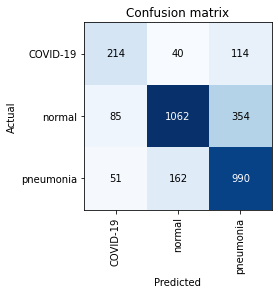

In [56]:
train_interp = learn.interpret(ds_type=DatasetType.Train)
train_interp.plot_confusion_matrix()

In [205]:
train_interp.confusion_matrix()
# joblib.dump(train_interp.confusion_matrix(), config.PROCESSED_DATA_DIR / 'confusion_matrix.pkl')


array([[ 214,   40,  114],
       [  85, 1062,  354],
       [  51,  162,  990]])

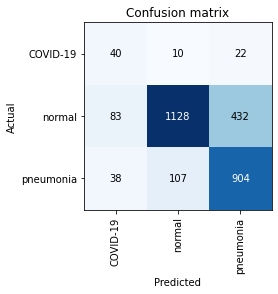

In [183]:
valid_interp = learn.interpret(ds_type=DatasetType.Valid)
valid_interp.plot_confusion_matrix()

In [147]:
# custom creation of validation conf matrix
print(data.valid_ds.classes)
valid_data = pd.DataFrame({'x': data.valid_ds.x.items, 'y': data.valid_ds.y.items})
valid_data['y_pred'] = valid_data.x.apply(lambda x: learn.predict(open_image(x)))
pred_tesnor = valid_data.y_pred.apply(lambda x: x[2].tolist()).to_list()
pred_tesnor = tensor(np.array(pred_tesnor))

['COVID-19', 'normal', 'pneumonia']


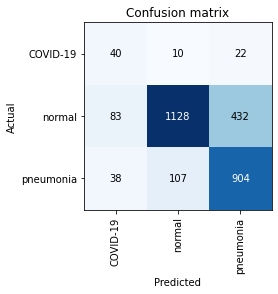

In [180]:
cus_valid_interp = ClassificationInterpretation(learn=learn, losses=np.zeros(valid_data.shape[0]),
                                                preds=pred_tesnor, 
                                                y_true=tensor(valid_data.y.to_list())
                                               )
cus_valid_interp.plot_confusion_matrix()

In [207]:
mat = cus_valid_interp.confusion_matrix()
mat

array([[  40,   10,   22],
       [  83, 1128,  432],
       [  38,  107,  904]])

In [218]:
np.trace(mat) / mat.sum() * 100


74.96382054992765

2072

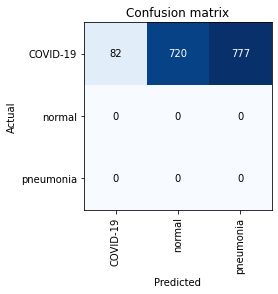

In [55]:
test_interp = learn.interpret(ds_type=DatasetType.Test)
test_interp.plot_confusion_matrix()

In [170]:
test_interp.preds.shape

torch.Size([1579, 3])

In [118]:
# test_interp.y_true  # missing

tensor([0, 0, 0,  ..., 0, 0, 0])

In [66]:
dir(data.test_ds)
y_pred = learn.get_preds(ds_type=DatasetType.Test)

In [79]:
pd.unique(y_pred[1].tolist())

array([0])

In [85]:
y_pred[0][0]

tensor([0.0256, 0.3513, 0.6231])

In [84]:
learn.predict(data.test_ds[0][0])

(Category tensor(2), tensor(2), tensor([0.0256, 0.3513, 0.6231]))

# Load model

In [8]:
from covid_xrays_model.processing.data_management import load_saved_learner, load_dataset
from fastai.vision import *

In [2]:
learn = load_saved_learner(with_focal_loss=False, with_oversampling=True, sample_size=5000)
data = load_dataset(sample_size=5000)
learn.data = data

In [3]:
learn.show_results()

RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(return_fig=True).savefig('figures/confusion_matrix.png', dpi=200)


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

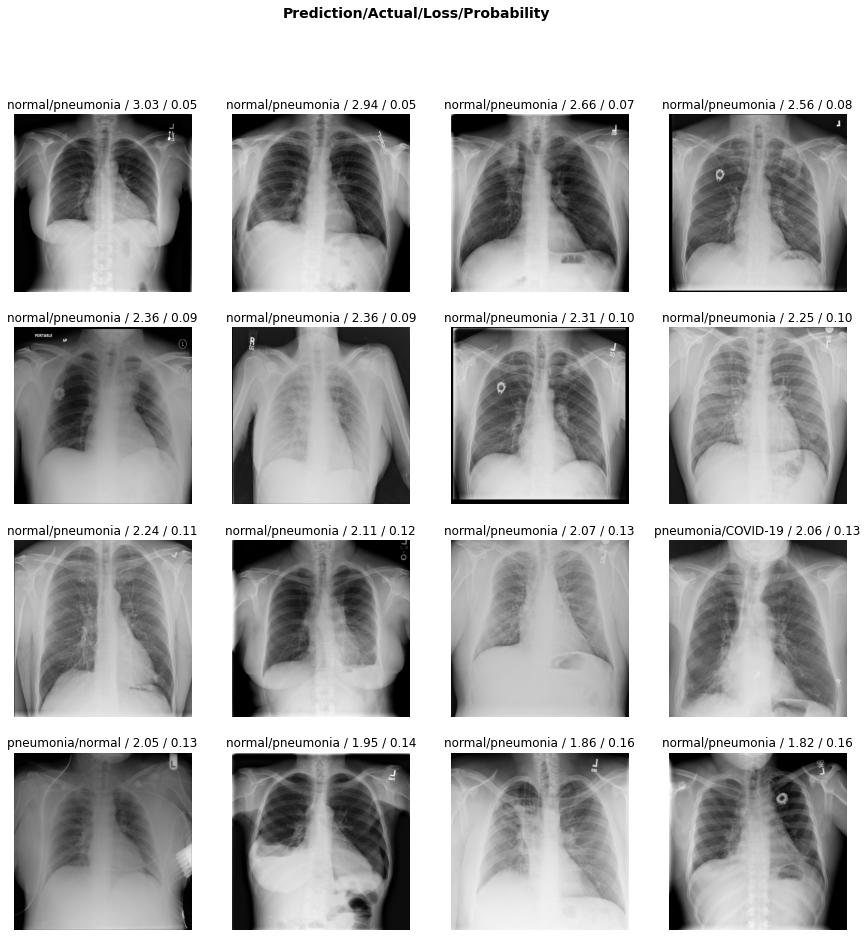

In [71]:
interp.plot_top_losses(16, largest=True, figsize=(15, 15))

In [64]:
learn = load_learner('/home/doaa/Git/covid_xrays/covid_xrays_model/covid_xrays_model/trained_models/', 'covid_xrays_model_output_v.pkl')

In [67]:
# learn.show_results(rows=3, figsize=(12,15))

In [12]:
pred = learn.predict(data.train_ds[0][0])
pred

(Category tensor(0), tensor(0), tensor([9.0441e-01, 2.2937e-05, 9.5564e-02]))

In [13]:
print(pred[0].obj, '-------', pred[0].data, '//', pred[1], '//', pred[2])

COVID-19 ------- tensor(0) // tensor(0) // tensor([9.0441e-01, 2.2937e-05, 9.5564e-02])


In [14]:
{k:float(v) for k, v in zip(learn.data.classes, pred[2])}

{'COVID-19': 0.9044130444526672,
 'normal': 2.2936616005608812e-05,
 'pneumonia': 0.09556407481431961}

In [15]:
learn.data.classes


['COVID-19', 'normal', 'pneumonia']

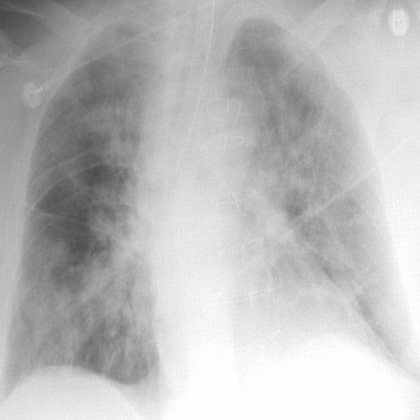

In [16]:
data.train_ds[0][0]


In [17]:
data.train_ds[0][1]


Category 2

In [18]:
print(data.train_ds.y[0].obj, '----', data.train_ds.y[0].data)

pneumonia ---- 2


In [232]:
x = np.array([[ 66,   8,  26],
 [  0, 835 , 50],
 [  1 , 39 ,554]])
x

array([[ 66,   8,  26],
       [  0, 835,  50],
       [  1,  39, 554]])

In [230]:
x[0][0]/x[0].sum()

0.66

In [231]:
x.sum()

1579

In [240]:
x[0][0]/x[:, 0].sum()

0.9850746268656716

In [241]:
x[0].sum()

100

In [245]:
dir(learn.loss_func)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__wrapped__',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_parameters',
 '_state_dict_hooks',
 'axis',
 'floatify',
 'func',
 'ignore_index',
 'is_2d',
 'reduction',
 'training',
 'weight']

In [250]:
learn.loss_func.reduction,   learn.loss_func.weight,    learn.loss_func.ignore_index,   learn.loss_func.func

('mean', None, -100, CrossEntropyLoss())

In [251]:
learn.loss_func.training

True

In [253]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [261]:
tensor(list(classes.values()))

tensor([0, 1, 2])

In [ ]:
cl